/Users/stuti_up_02/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.76      0.81     12809
           1       0.65      0.78      0.71      7191

    accuracy                           0.77     20000
   macro avg       0.75      0.77      0.76     20000
weighted avg       0.78      0.77      0.77     20000

AUC Score: 0.8509284366146782


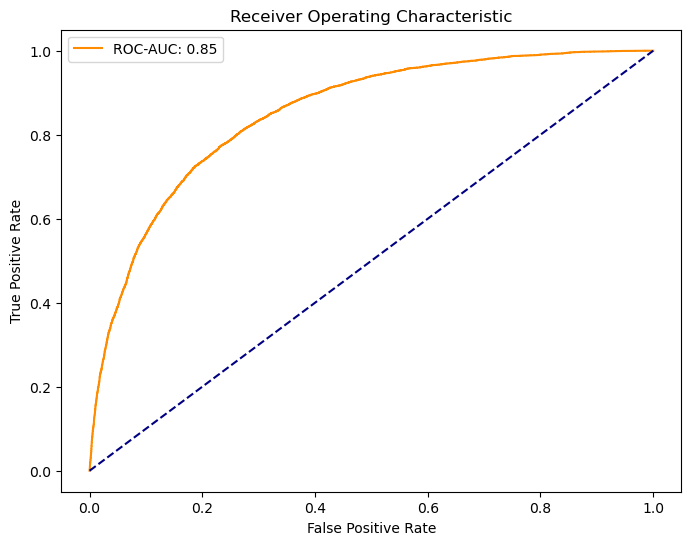

In [1]:
from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV


class TestModel:
    def __init__(self):
        # loading the trained model from the pickle file
        with open('best_model_pipeline.pkl', 'rb') as f: 
             self.model = pickle.load(f)

    def predict(self, X):
        """Makes predictions using the loaded model."""
        return self.model.predict(X)
    
    def predict_proba(self, X):
        """Predicts class probabilities using the loaded model."""
        return self.model.predict_proba(X)

def production(X_path, y_path):
    """
    Loads data, preprocesses it, makes predictions using the trained model,
    and prints a classification report.

    Args:
        X_path (str): Path to the CSV file containing the features (X data).
        y_path (str): Path to the CSV file containing the target variable (y data).
    """
    # Load the trained model
    model = TestModel()

    # Load data
    df_X = pd.read_csv(X_path)
    df_y = pd.read_csv(y_path)['Left']

    # -------------------------
    # Preprocessing Steps
    df_X['Salary'] = df_X['Salary'].str.replace('K', '').astype(float) * 1000
    df_X['PreviousSalary'] = df_X['PreviousSalary'].str.replace('K', '').astype(float) * 1000

    # Handle missing values
    df_X['Distance'] = df_X['Distance'].fillna(df_X['Distance'].mode()[0])  
    df_X['SelfReview'] = df_X['SelfReview'].fillna(df_X['SelfReview'].mode()[0])
    df_X['SupervisorReview'] = df_X['SupervisorReview'].fillna(df_X['SupervisorReview'].mode()[0])

    # Additional feature engineering
    df_X['JobMentalWellbeing'] = df_X[['PeerFeedbackScore', 'WorkSatisfactionScore', 'JobEngagementScore']].mean(axis=1)
    df_X['Salary_Percentage_Increase'] = ((df_X['Salary'] - df_X['PreviousSalary']) / df_X['PreviousSalary']) * 100
    
    # Creating preprocessor
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    numerical_features = ['PreviousSalary', 'YearsWorked', 'NumOfProjects', 'TeamSize',
                          'WorkSatisfactionScore', 'JobEngagementScore', 'MentalWellbeingScore', 'Salary']

    categorical_features = ['Gender', 'MentorshipReceived', 'SkillDevelopmentCourses',
                            'Distance', 'DepartmentCode', 'WorkLifeBalance', 'JobInvolvement',
                            'TechSkillLevel', 'StressLevel', 'ProjectComplexity', 'SelfReview',
                            'SupervisorReview']

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  
        ('scaler', StandardScaler()) 
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')) 
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_features),
        ('cat', cat_pipeline, categorical_features)
    ])

    # Fit the preprocessor
    preprocessor.fit(df_X)

    # Transform the data using the fitted preprocessor
    X_transformed = preprocessor.transform(df_X)

    # -------------------------
    # Split the Data into Train and Test Sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_transformed, df_y, test_size=0.2, random_state=42, stratify=df_y
    )

    # Apply SMOTE to the Training Set Only
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # -------------------------
    # Hyperparameter Tuning
    from sklearn.linear_model import LogisticRegression

    # Define hyperparameter distributions
    param_distributions = {
        'C': np.logspace(-3, 3, 7),  # Regularization strength
        'class_weight': [{0: 1, 1: w} for w in np.linspace(1, 5, 10)]
    }

    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=LogisticRegression(max_iter=500, random_state=42),
        param_distributions=param_distributions,
        n_iter=50,
        scoring='precision',
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train_resampled, y_train_resampled)

    # Retrieve the best model
    best_model = random_search.best_estimator_

    # -------------------------
    # Predictions and Evaluation
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC Score: {auc_score}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr,color='darkorange', label=f"ROC-AUC: {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()
    
# calling the function to test 
production( 
    X_path='https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final4/employee_departure_dataset_X_prod.csv',
    y_path='https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/final4/employee_departure_dataset_y_prod.csv'
)

### Conclusion: 

- Here in our case, the relatively lower precision for class 1 which is the employed that departed, it is basically suggesting a focus on improving the model's ability to identify true positives without increasing false positives too much. 
- Some improvements for us can be addressing class imbalance and feature engineering.